**Assignment 3: Kernel Ridge Regression**

*CPSC 381/581: Machine Learning*

*Yale University*

*Instructor: Alex Wong*


**Prerequisites**:

1. Enable Google Colaboratory as an app on your Google Drive account

2. Create a new Google Colab notebook, this will also create a "Colab Notebooks" directory under "MyDrive" i.e.
```
/content/drive/MyDrive/Colab Notebooks
```

3. Create the following directory structure in your Google Drive
```
/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Assignments
```

4. Move the 03_assignment_kernel_regression.ipynb into
```
/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Assignments
```
so that its absolute path is
```
/content/drive/MyDrive/Colab Notebooks/CPSC 381-581: Machine Learning/Assignments/03_assignment_kernel_ridge_regression.ipynb
```

In this assignment, we will optimize a kernelized linear function in nonlinear space. We will implement several kernels (linear, polynomial, radial basis function) and train a kernel ridge regression model. We will benchmark our implementation against the one from sci-kit learn, where we should be comparable. Additionally, we will test the speed up for using kernels when the nonlinear mapping function expands feature to high dimensions.


**Submission**:

1. Implement all TODOs in the code blocks below.

2. Report your training and validation/testing scores.

```
All scores match Sci-kit Learn:
Preprocessing the Diabetes dataset (442 samples, 10 feature dimensions)
***** Experiments on the Diabetes dataset using linear kernel ridge regression model with weight decay of 0.01 *****
Results for Scikit-learn model
Training set mean squared error: 25889.5196
Validation set mean squared error: 26708.7982
Testing set mean squared error: 26229.5319
Results for our model
Training set mean squared error: 25889.5196
Validation set mean squared error: 26708.7982
Testing set mean squared error: 26229.5319
***** Experiments on the Diabetes dataset using polynomial (degree=3) kernel ridge regression model with weight decay of 0.01 *****
Results for Scikit-learn model
Training set mean squared error: 2458.3355
Validation set mean squared error: 2746.9815
Testing set mean squared error: 3498.1709
Results for our model
Training set mean squared error: 2458.3355
Validation set mean squared error: 2746.9815
Testing set mean squared error: 3498.1709
***** Experiments on the Diabetes dataset using rbf (gamma=1) kernel ridge regression model with weight decay of 0.01 *****
Results for Scikit-learn model
Training set mean squared error: 2510.6872
Validation set mean squared error: 2697.5951
Testing set mean squared error: 3476.3020
Results for our model
Training set mean squared error: 2510.6872
Validation set mean squared error: 2697.5951
Testing set mean squared error: 3476.3020

Preprocessing the Friedman #1 dataset (5000 samples, 20 feature dimensions)
***** Experiments on the Friedman #1 dataset using linear kernel ridge regression model with weight decay of 0.0001 *****
Results for Scikit-learn model
Training set mean squared error: 5.9711
Validation set mean squared error: 6.0310
Testing set mean squared error: 5.9807
Results for our model
Training set mean squared error: 5.9711
Validation set mean squared error: 6.0310
Testing set mean squared error: 5.9807
***** Experiments on the Friedman #1 dataset using polynomial (degree=3) kernel ridge regression model with weight decay of 0.0001 *****
Results for Scikit-learn model
Training set mean squared error: 0.0354
Validation set mean squared error: 0.2606
Testing set mean squared error: 0.2580
Results for our model
Training set mean squared error: 0.0354
Validation set mean squared error: 0.2606
Testing set mean squared error: 0.2580
***** Experiments on the Friedman #1 dataset using rbf (gamma=1) kernel ridge regression model with weight decay of 0.0001 *****
Results for Scikit-learn model
Training set mean squared error: 0.0000
Validation set mean squared error: 3.8152
Testing set mean squared error: 3.8152
Results for our model
Training set mean squared error: 0.0000
Validation set mean squared error: 3.8152
Testing set mean squared error: 3.8152


AND Kernel ridge regression is faster at 4th and 5th order(see graph at bottom)

Training ridge regression model with degree 2 polynomial expansion with 5000 samples, 231 feature dimensions
Training time: 4.39ms
Training kernel ridge regression model with degree 2 polynomial with 5000 samples, 20 feature dimensions
Training time: 754.66ms

Training ridge regression model with degree 3 polynomial expansion with 5000 samples, 1771 feature dimensions
Training time: 87.95ms
Training kernel ridge regression model with degree 3 polynomial with 5000 samples, 20 feature dimensions
Training time: 770.12ms

Training ridge regression model with degree 4 polynomial expansion with 5000 samples, 10626 feature dimensions
Training time: 964.51ms
Training kernel ridge regression model with degree 4 polynomial with 5000 samples, 20 feature dimensions
Training time: 768.82ms

Training ridge regression model with degree 5 polynomial expansion with 5000 samples, 53130 feature dimensions
Training time: 3104.30ms
Training kernel ridge regression model with degree 5 polynomial with 5000 samples, 20 feature dimensions
Training time: 799.67ms

```

3. List any collaborators.

```
None
```


**IMPORTANT**:

- For full credit, your mean squared error for all trained models across all datasets should be same as the scores achieved by sci-kit learn's kernel ridge regression model across training, validation and testing splits. Your kernel ridge regression must be faster than sci-kit linear regression with polynomial expansion at 4th order.

In [19]:
import numpy as np
import sklearn.datasets as skdata
import sklearn.metrics as skmetrics
import sklearn.preprocessing as skpreprocess
from sklearn.linear_model import Ridge as RidgeRegressionSciKit
from sklearn.kernel_ridge import KernelRidge as KernelRidgeRegressionSciKit
from matplotlib import pyplot as plt
import warnings
import time

warnings.filterwarnings(action='ignore')
np.random.seed = 1

Helper function for plotting

In [20]:
def plot_results(axis,
                 x_values,
                 y_values,
                 labels,
                 colors,
                 x_limits,
                 y_limits,
                 x_label,
                 y_label):
    '''
    Plots x and y values using line plot with labels and colors

    Args:
        axis :  pyplot.ax
            matplotlib subplot axis
        x_values : list[numpy[float32]]
            list of numpy array of x values
        y_values : list[numpy[float32]]
            list of numpy array of y values
        labels : str
            list of names for legend
        colors : str
            colors for each line
        x_limits : list[float32]
            min and max values of x axis
        y_limits : list[float32]
            min and max values of y axis
        x_label : list[float32]
            name of x axis
        y_label : list[float32]
            name of y axis
    '''

    # Iterate through x_values, y_values, labels, and colors and plot them
    # with associated legend
    for x, y, label, color in zip(x_values, y_values, labels, colors):
        axis.plot(x, y, marker='o', color=color, label=label)
        axis.legend(loc='best')

    # Set x and y limits
    axis.set_xlim(x_limits)
    axis.set_ylim(y_limits)

    # Set x and y labels
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

Implementation of kernel ridge regression

In [21]:
class KernelRidgeRegression(object):

    def __init__(self, kernel_func, degree=None, gamma=None):
        '''
        Class for kernel ridge regression

        Arg(s):
            kernel_func : str
                name of kernel function to use: linear, polynomial, rbf (gaussian)
            degree : int
                p-order for polynomial
            gamma : float
                standard deviation of the Gaussian
        '''

        # Define private variables
        self.__weights = None
        self.__X = None
        self.__kernel_func = kernel_func
        self.__degree = degree
        self.__gamma = gamma

    def __linear_kernel(self, X1, X2):
        '''
        Computes the linear kernel function on X1 and X2

        Arg(s):
            X1 : numpy[float32]
                N x d feature vector
            X2 : numpy[float32]
                N x d feature vector
        Returns:
            numpy[float32] : N x N kernel matrix
        '''

        # TODO: Implement linear kernel
        return np.dot(X1, X2.T)


    def __polynomial_kernel(self, X1, X2, degree):
        '''
        Computes the p-order polynomial kernel function on X1 and X2 with c = 1

        Arg(s):
            X1 : numpy[float32]
                N x d feature vector
            X2 : numpy[float32]
                N x d feature vector
            degree : int
                p-order for polynomial
        Returns:
            numpy[float32] : N x N kernel matrix
        '''

        c = 1
        return np.power(X1.dot(X2.T) + c, degree)

    def __rbf_kernel(self, X1, X2, gamma):
        '''
        Computes the RBF (Gaussian) kernel function on X1 and X2

        Arg(s):
            X1 : numpy[float32]
                N x d feature vector
            X2 : numpy[float32]
                N x d feature vector
            gamma : float
                standard deviation of the Gaussian
        Returns:
            numpy[float32] : N x N kernel matrix
        '''

        # TODO: Implement RBF kernel using Gaussian form
        diff = X1[:, np.newaxis, :] - X2[np.newaxis, :, :]
        numerator = np.sum(diff ** 2, axis=2)
        return np.exp(-gamma * numerator)
        
      


    def fit(self, X, y, weight_decay=0):
        '''
        Fits the model to X and y via normal equation in kernelized form

        Arg(s):
            X : numpy[float32]
                N x d feature vector
            y : numpy[float32]
                N x 1 ground-truth label
            weight_decay : float
                weight of weight decay term
        '''

        # TODO: Implement the fit function
        self.__X = X.copy()   

        if self.__kernel_func == 'linear':
            K = self.__linear_kernel(X, X)

        elif self.__kernel_func == 'polynomial':
            K = self.__polynomial_kernel(X, X, self.__degree)

        elif self.__kernel_func == 'rbf':
            K = self.__rbf_kernel(X, X, self.__gamma)

        else:
            raise ValueError('Unsupported kernel function: {}'.format(self.__kernel_func))
        A = K + weight_decay * np.eye(K.shape[0])
        self.__weights = np.linalg.solve(A, y)  

    def predict(self, X):
        '''
        Predicts the real value for each feature vector X

        Arg(s):
            x : numpy[float32]
                N x d feature vector
        Returns:
            numpy[float32] : N x 1 real value vector (\hat{y})
        '''

        # TODO: Implement the predict function

        if self.__kernel_func == 'linear':
            K = self.__linear_kernel(X, self.__X)

        elif self.__kernel_func == 'polynomial':
            K = self.__polynomial_kernel(X, self.__X, self.__degree)

        elif self.__kernel_func == 'rbf':
            K = self.__rbf_kernel(X, self.__X, self.__gamma)

        else:
            raise ValueError('Unsupported kernel function: {}'.format(self.__kernel_func))

        return np.dot(K, self.__weights)


Load datasets

In [22]:
# Load diabetes and Friedman #1 datasets
datasets = [
    skdata.load_diabetes(),
    skdata.make_friedman1(n_samples=5000, n_features=20, noise=0.0, random_state=1)
]

dataset_names = [
    'Diabetes',
    'Friedman #1'
]


Training, validating and testing kernel ridge regression

In [23]:
# Set hyperparameters
diabetes_weight_decay = 1e-2
diabetes_degree = 3
diabetes_gamma = 1

friedman1_weight_decay = 1e-4
friedman1_degree = 3
friedman1_gamma = 1

dataset_hyperparameters = [
    # For diabetes dataset
    [
        diabetes_weight_decay,
        diabetes_degree,
        diabetes_gamma
    ],
    # For Friedman #1 dataset
    [
        friedman1_weight_decay,
        friedman1_degree,
        friedman1_gamma
    ]
]

# Zip up all dataset options
dataset_options = zip(
    datasets,
    dataset_names,
    dataset_hyperparameters)


for options in dataset_options:

    # Unpack dataset options
    dataset, \
        dataset_name, \
        dataset_hyperparameters = options

    weight_decay, degree, gamma = dataset_hyperparameters

    '''
    Create the training, validation and testing splits
    '''
    if dataset_name == 'Friedman #1':
        X, y = dataset
    else:
        X = dataset.data
        y = dataset.target


    print('Preprocessing the {} dataset ({} samples, {} feature dimensions)'.format(dataset_name, X.shape[0], X.shape[1]))

    # Shuffle the dataset based on sample indices
    shuffled_indices = np.random.permutation(X.shape[0])

    # Choose the first 60% as training set, next 20% as validation and the rest as testing
    train_split_idx = int(0.60 * X.shape[0])
    val_split_idx = int(0.80 * X.shape[0])

    train_indices = shuffled_indices[0:train_split_idx]
    val_indices = shuffled_indices[train_split_idx:val_split_idx]
    test_indices = shuffled_indices[val_split_idx:]

    # Select the examples from X and y to construct our training, validation, testing sets
    X_train, y_train = X[train_indices, :], y[train_indices]
    X_val, y_val = X[val_indices, :], y[val_indices]
    X_test, y_test = X[test_indices, :], y[test_indices]

    for kernel in ['linear', 'polynomial', 'rbf']:

        '''
        Trains and tests kernel ridge regression model for different kernels
        '''

        if kernel == 'linear':
            print('***** Experiments on the {} dataset using {} kernel ridge regression model with weight decay of {} *****'.format(
                dataset_name,
                kernel,
                weight_decay))

            # TODO: Instantiate KernelRidgeRegressionSciKit with linear kernel
            model_scikit = KernelRidgeRegressionSciKit(kernel=kernel, alpha=weight_decay)

            # TODO: Instantiate our kernel ridge regression model with linear kernel
            model_ours = KernelRidgeRegression('linear')

        elif kernel == 'polynomial':
            print('***** Experiments on the {} dataset using {} (degree={}) kernel ridge regression model with weight decay of {} *****'.format(
                dataset_name,
                kernel,
                degree,
                weight_decay))

            # TODO: Instantiate KernelRidgeRegressionSciKit with a polynomial kernel with specified degree and gamma of 1
            model_scikit = KernelRidgeRegressionSciKit(kernel=kernel, alpha=weight_decay, degree=degree, gamma=1)

            # TODO: Instantiate our kernel ridge regression model with polynomial kernel with specified degree
            model_ours = KernelRidgeRegression('polynomial', degree=degree)

        elif kernel == 'rbf':
            print('***** Experiments on the {} dataset using {} (gamma={}) kernel ridge regression model with weight decay of {} *****'.format(
                dataset_name,
                kernel,
                gamma,
                weight_decay))

            # TODO: Instantiate KernelRidgeRegressionSciKit with an rbf kernel. Please choose gamma for Scikit. Note: Scikit implementation using gamma is as follows: 1 / (2 * specified gamma ** 2)
            model_scikit = KernelRidgeRegressionSciKit(kernel=kernel, alpha=weight_decay, gamma=gamma)

            # TODO: Instantiate our kernel ridge regression model with an rbf kernel with specified gamma
            model_ours = KernelRidgeRegression('rbf', gamma=gamma)
        else:
            raise ValueError('Unsupported kernel function: {}'.format(kernel))

        print('Results for Scikit-learn model')

        # TODO: Train scikit-learn model
        model_scikit.fit(X_train, y_train)

        # TODO: Score model using mean squared error on training set
        predictions_scikit_train = model_scikit.predict(X_train)
        mse_scikit_train = skmetrics.mean_squared_error(y_train, predictions_scikit_train)
        print('Training set mean squared error: {:.4f}'.format(mse_scikit_train))

        # TODO: Score model using mean squared error validation set

        mse_scikit_val = skmetrics.mean_squared_error(y_val, model_scikit.predict(X_val))
        print('Validation set mean squared error: {:.4f}'.format(mse_scikit_val))

        # TODO: Score model using mean squared error testing set

        mse_scikit_test = skmetrics.mean_squared_error(y_test, model_scikit.predict(X_test))
        print('Testing set mean squared error: {:.4f}'.format(mse_scikit_test))

        print('Results for our model')

        # TODO: Train our model
        model_ours.fit(X_train, y_train, weight_decay)


        # TODO: Score model using mean squared error on training set

        mse_ours_train = skmetrics.mean_squared_error(np.squeeze(y_train), np.squeeze(model_ours.predict(X_train)))
        print('Training set mean squared error: {:.4f}'.format(mse_ours_train))

        # TODO: Score model using mean squared error validation set

        mse_ours_val = skmetrics.mean_squared_error(np.squeeze(y_val), np.squeeze(model_ours.predict(X_val)))
        print('Validation set mean squared error: {:.4f}'.format(mse_ours_val))

        # TODO: Score model using mean squared error testing set

        mse_ours_test = skmetrics.mean_squared_error(np.squeeze(y_test), np.squeeze(model_ours.predict(X_test)))
        print('Testing set mean squared error: {:.4f}'.format(mse_ours_test))

    print('')

Preprocessing the Diabetes dataset (442 samples, 10 feature dimensions)
***** Experiments on the Diabetes dataset using linear kernel ridge regression model with weight decay of 0.01 *****
Results for Scikit-learn model
Training set mean squared error: 26221.6241
Validation set mean squared error: 26310.9583
Testing set mean squared error: 26436.4242
Results for our model
Training set mean squared error: 26221.6241
Validation set mean squared error: 26310.9583
Testing set mean squared error: 26436.4242
***** Experiments on the Diabetes dataset using polynomial (degree=3) kernel ridge regression model with weight decay of 0.01 *****
Results for Scikit-learn model
Training set mean squared error: 2402.3747
Validation set mean squared error: 3476.8757
Testing set mean squared error: 3023.2954
Results for our model
Training set mean squared error: 2402.3747
Validation set mean squared error: 3476.8757
Testing set mean squared error: 3023.2954
***** Experiments on the Diabetes dataset using

Comparing run time for polynomial kernel and polynomial feature expansion

Training ridge regression model with degree 2 polynomial expansion with 5000 samples, 231 feature dimensions
Training time: 5.46ms
Training kernel ridge regression model with degree 2 polynomial with 5000 samples, 20 feature dimensions
Training time: 729.92ms

Training ridge regression model with degree 3 polynomial expansion with 5000 samples, 1771 feature dimensions
Training time: 87.50ms
Training kernel ridge regression model with degree 3 polynomial with 5000 samples, 20 feature dimensions
Training time: 747.73ms

Training ridge regression model with degree 4 polynomial expansion with 5000 samples, 10626 feature dimensions
Training time: 995.10ms
Training kernel ridge regression model with degree 4 polynomial with 5000 samples, 20 feature dimensions
Training time: 812.18ms

Training ridge regression model with degree 5 polynomial expansion with 5000 samples, 53130 feature dimensions
Training time: 3843.72ms
Training kernel ridge regression model with degree 5 polynomial with 5000 s

Text(0.5, 1.0, 'Comparing Polynomial Feature Expansion and Polynomial Kernel Run-times')

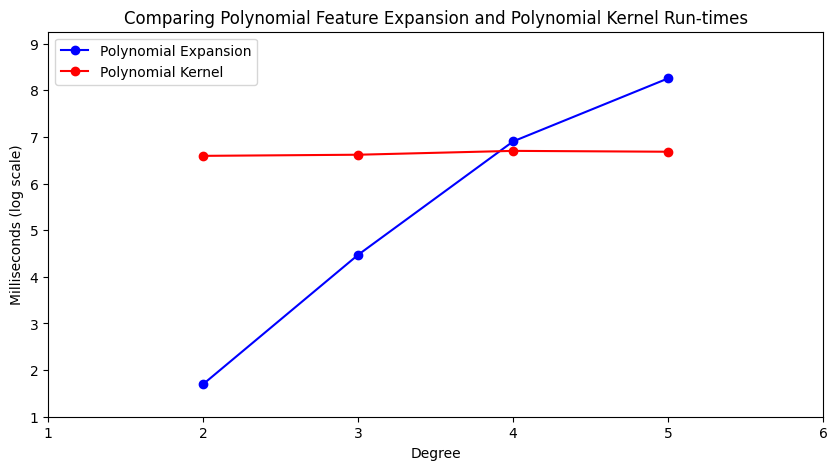

In [24]:
# Define weight decay and polynomial degrees
weight_decay = 1

degrees = [
    2, 3, 4, 5
]

# Lists to hold time elapsed for
times_elapsed_poly_expand = []
times_elapsed_poly_kernel = []

# Select Friedman #1 dataset
dataset = skdata.make_friedman1(n_samples=5000, n_features=20, noise=1.0, random_state=1)

X, y = dataset

for degree in degrees:

    # TODO: Initialize polynomial expansion
    poly_transform = skpreprocess.PolynomialFeatures(degree=degree)

    # TODO: Compute the polynomial terms needed for the data
    poly_transform.fit(X)

    # TODO: Transform the data by nonlinear mapping
    X_poly = poly_transform.transform(X)

    # TODO: Initialize sci-kit ridge regression model
    model_poly_expand = RidgeRegressionSciKit(alpha=weight_decay)

    print('Training ridge regression model with degree {} polynomial expansion with {} samples, {} feature dimensions'.format(
        degree,
        X_poly.shape[0],
        X_poly.shape[1]))

    time_start = time.time()

    # TODO: Train sci-kit ridge regression model on polynomial expanded X
    model_poly_expand.fit(X_poly, y)

    time_elapsed_poly_expand = 1000 * (time.time() - time_start)

    print('Training time: {:.2f}ms'.format(time_elapsed_poly_expand))

    # TODO: Append training time to list of time elapsed for polynomial feature expansion
    times_elapsed_poly_expand.append(time_elapsed_poly_expand)


    # TODO: Initialize our polynomial kernel ridge regression model
    model_poly_kernel = KernelRidgeRegression('polynomial', degree=degree)

    print('Training kernel ridge regression model with degree {} polynomial with {} samples, {} feature dimensions'.format(
        degree,
        X.shape[0],
        X.shape[1]))

    time_start = time.time()

    # TODO: Train our polynomial kernel ridge regression model on X
    model_poly_kernel.fit(X, y, weight_decay)

    time_elapsed_poly_kernel = 1000 * (time.time() - time_start)

    print('Training time: {:.2f}ms'.format(time_elapsed_poly_kernel))

    # TODO: Append training time to list of time elapsed for polynomial kernel
    times_elapsed_poly_kernel.append(time_elapsed_poly_kernel)


    print('')


# Create figure for training, validation and testing scores for different features
labels = ['Polynomial Expansion', 'Polynomial Kernel']
colors = ['blue', 'red']

# TODO: Create a subplot of a 1 by 1 figure to plot MSE for training and testing
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# TODO: Set x values (polynomial degree) and y values (time in ms in log scale)
x_values = [degrees] * 2
y_values = [times_elapsed_poly_expand, times_elapsed_poly_kernel]
y_values = [np.log(y) for y in y_values]

# TODO: Plot MSE scores for training and testing sets
# Set x limits between 1 to 1 + maximum value of all degrees and y limits between 1 and 1 + maximum value of all log time in ms
# Set x label to degree and y label to milliseconds (log scale)' and y label to 'MSE',
plot_results(
    axis=ax,
    x_values=x_values,
    y_values=y_values,
    labels=labels,
    colors=colors,
    x_limits=[1, max(degrees) + 1],
    y_limits=[1, max(max(y_values[0]), max(y_values[1])) + 1],
    x_label='Degree',
    y_label='Milliseconds (log scale)')


# TODO: Create plot title of 'Comparing Polynomial Feature Expansion and Polynomial Kernel Run-times'
plt.title('Comparing Polynomial Feature Expansion and Polynomial Kernel Run-times')


